In [1]:
from __future__ import division

import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt

import torch
import torchvision.utils as vutils
from scipy.io import loadmat, savemat
import numpy as np
import argparse
from torch.autograd import Variable

from loaders import locations, getLoaders
from models import getModels


def extractPercentileStats(trainProbs, testProbs):
    sortedInds = np.argsort(np.concatenate([trainProbs, testProbs]))
    trainTest = np.concatenate([np.ones(len(trainProbs), dtype='int'),np.zeros(len(testProbs),dtype='int')])
    trainTest = trainTest[sortedInds]
    cumulative = np.cumsum(trainTest)
    testPercentiles = cumulative[trainTest==0]/float(len(trainProbs))
    return testPercentiles

def heatmap(net):
    grid0, grid1 = np.meshgrid(np.linspace(-1.5,1.5,100),np.linspace(1.5,-1.5,100))
    print grid0.shape, grid1.shape
    pts = np.zeros((10000,2))
    for i in range(100):
        for j in range(100):
            pts[i*100+j,:] = grid0[i,j],grid1[i,j]
    ptsTorch = Variable(torch.from_numpy(pts.astype(np.float32)))
    vals, logp = net.invert(ptsTorch)
    probsNumpy = logp.data.numpy().reshape((100,100))
  #  print probsNumpy[:5,:5]
    transformed = np.exp(probsNumpy)
   # transformed = probsNumpy[probsNumpy<probsNumpy.mean()]=probsNumpy.mean()
    plt.imshow(transformed)
    
def hiLow(pdict, number=64, imageArray=None, nrow=8):
    if imageArray is None:
        ims = pdict['images']
    else:
        ims = imageArray
        
    probs = pdict['probs'].squeeze()
    inds = np.argsort(probs)
    
    imsTop = torch.from_numpy(ims[inds[-number:]])
    imsBot = torch.from_numpy(ims[inds[:number]])
    
    topGrid = vutils.make_grid(imsTop, nrow=nrow, normalize=True)
    botGrid = vutils.make_grid(imsBot, nrow=nrow, normalize=True)
    
    #if hi:
    plt.figure(figsize=(15,15))
    plt.imshow(topGrid.numpy().transpose((1,2,0)))
    #else:
    plt.figure(figsize=(15,15))
    plt.imshow(botGrid.numpy().transpose((1,2,0)))
    
    

def percentiles():
    pass


(100, 100) (100, 100)


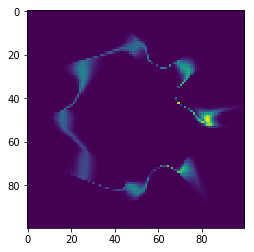

In [28]:
net = getModels('mogNVP')[0]
net.load_state_dict(torch.load('generated/final/mog_flowgan_mixed/netG_10.pth', lambda s,t:s))
heatmap(net)

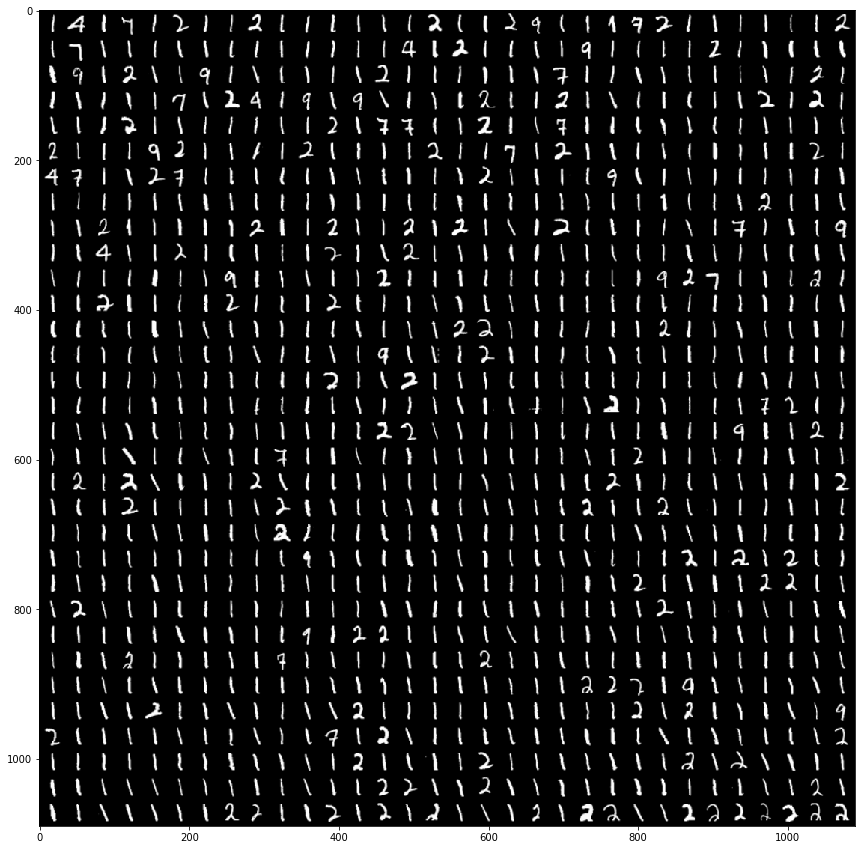

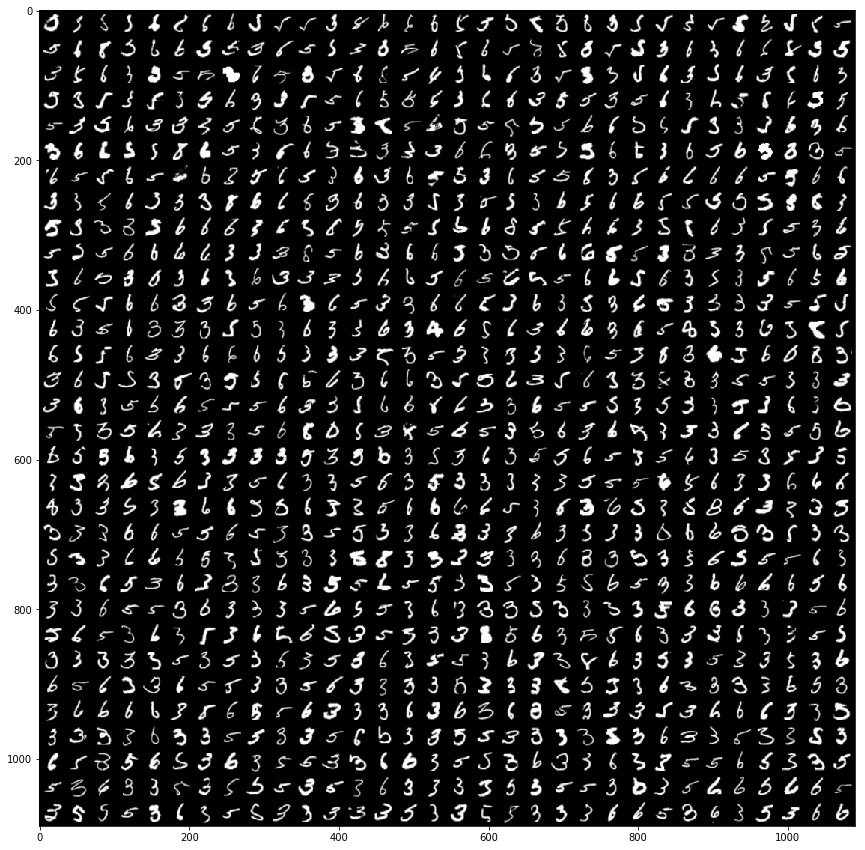

In [31]:
# Visualize sorted mnist via densenet
m = getLoaders('mnist', datasetOnly=True)
p = loadmat('generated/final/deepgan/mnist10_improved/rsamples/mnistViaDeepRegressor.mat')['probs']
#p = p.squeeze()
hiLow({'images':m.X, 'probs':p}, number=1024, nrow=32)

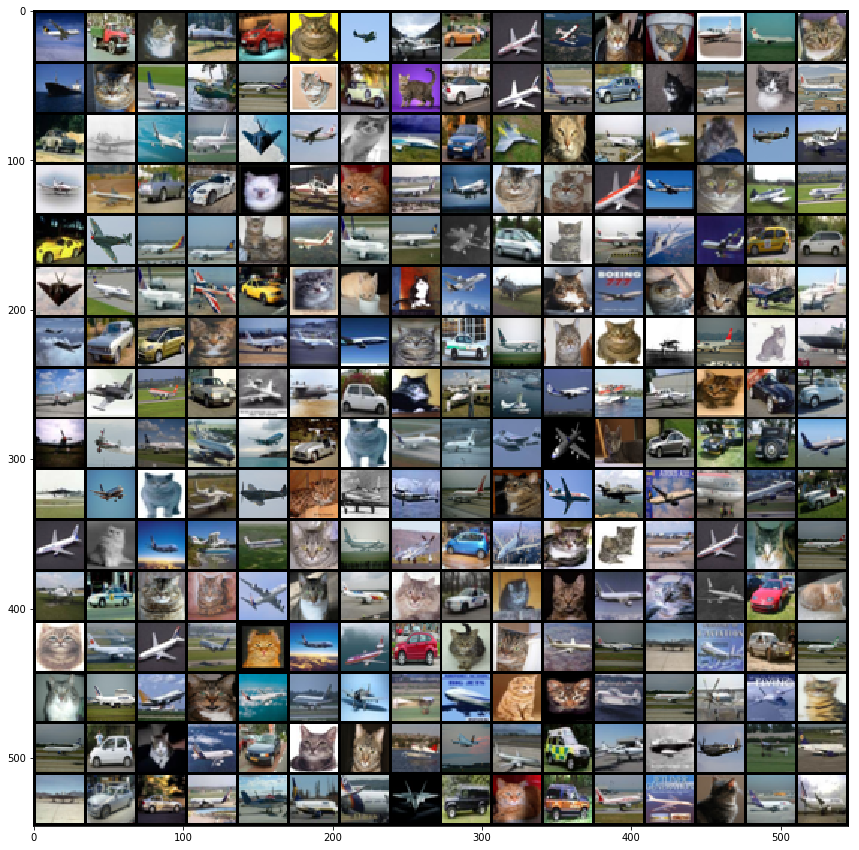

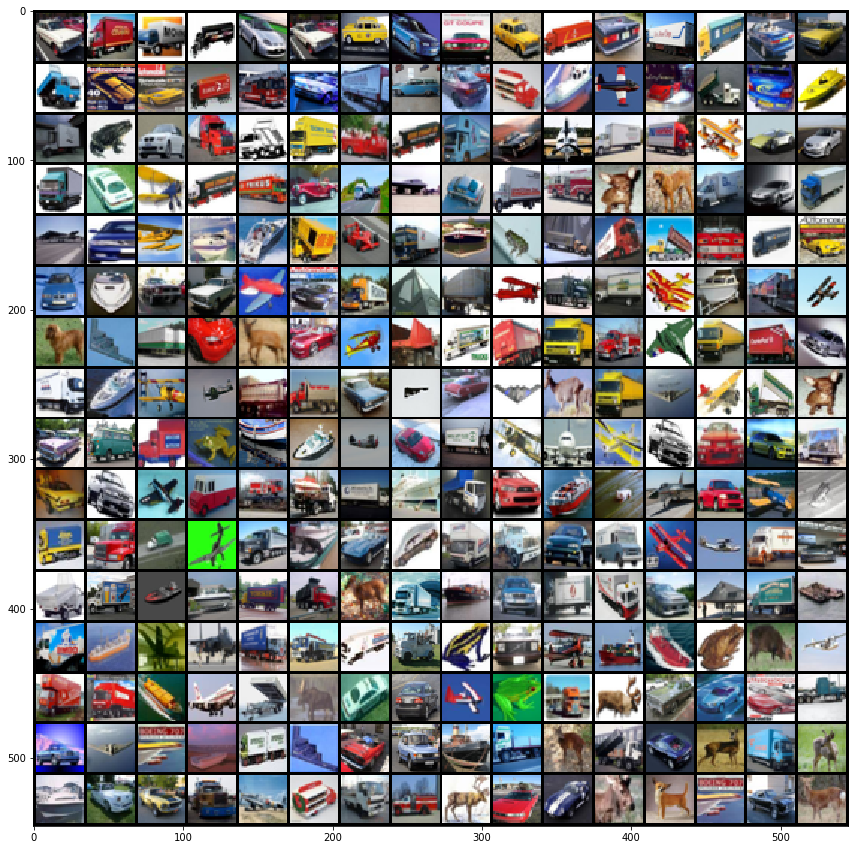

In [4]:
# Visualize sorted mnist via densenet
m = getLoaders('cifar10', datasetOnly=True)
p = loadmat('generated/final/deepgan/cifar10/rsample/cifarViaDeepRegressor.mat')['probs']
#p = p.squeeze()
hiLow({'images':m.X, 'probs':p}, number=256, nrow=16)

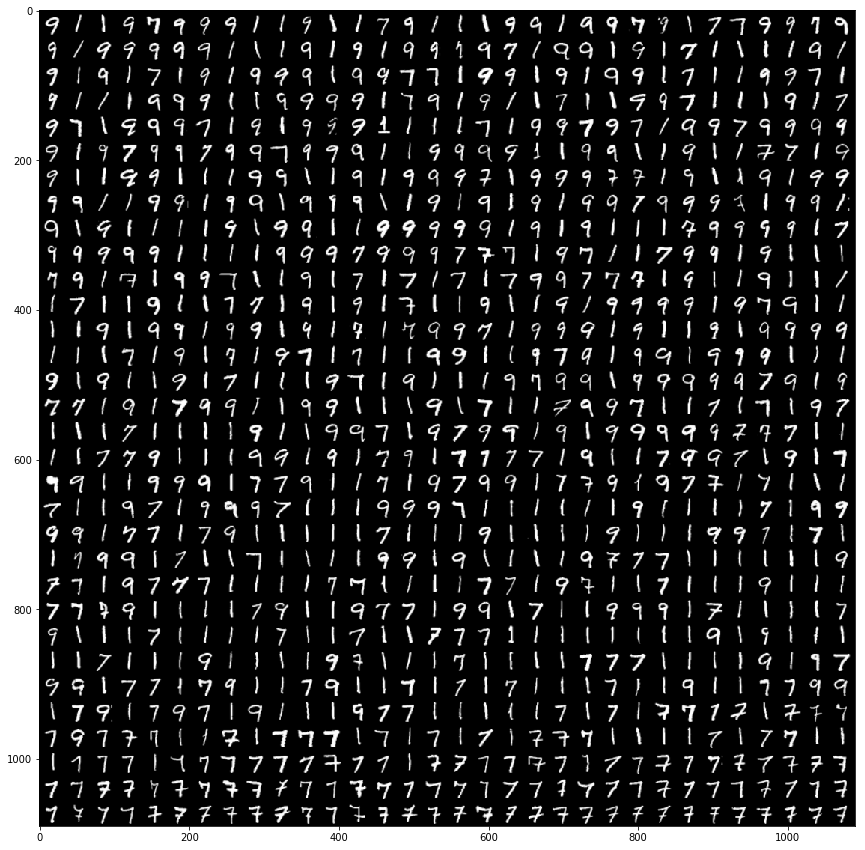

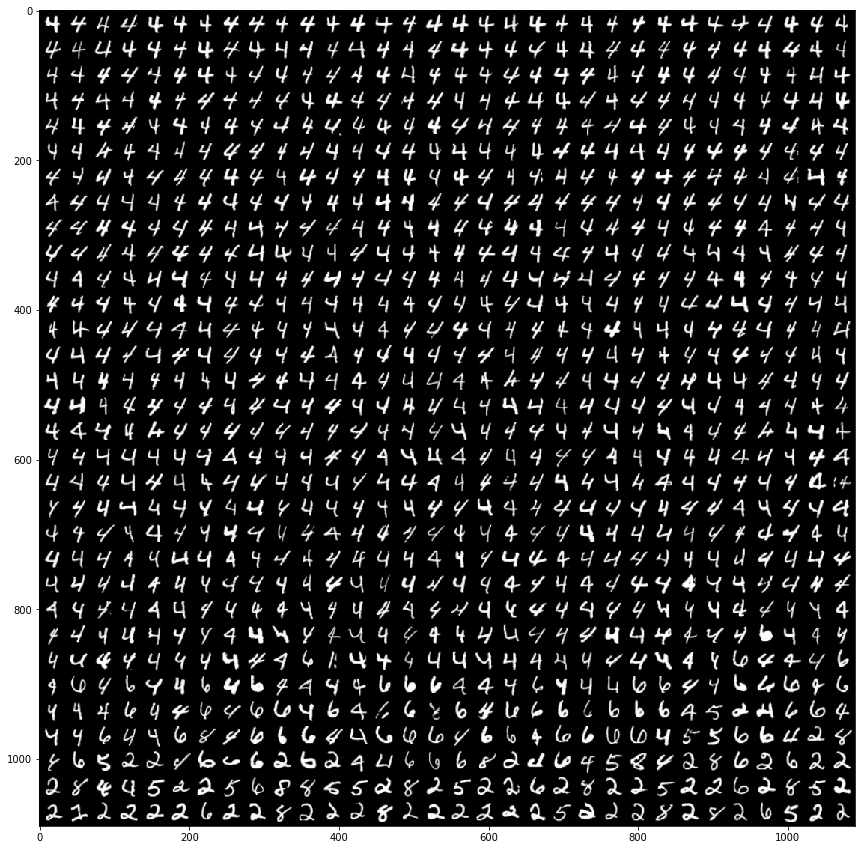

In [6]:
# Visualize sorted mnist via densenet
m = getLoaders('mnist', datasetOnly=True, mode='test')
p = loadmat('generated/final/deepgan/mnist384/rsample/mnistViaDeepRegressorTest.mat')['probs']
#p = p.squeeze()
hiLow({'images':m.X, 'probs':p}, number=1024, nrow=32)

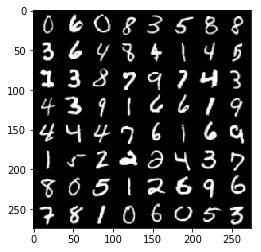

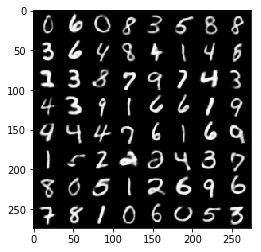

In [12]:
from autoencoder import Encoder, Decoder
enc = Encoder()
dec = Decoder()
enc.load_state_dict(torch.load('generated/final/mnist_autoencoder/netEnc_10.pth',lambda s,t: s))
dec.load_state_dict(torch.load('generated/final/mnist_autoencoder/netDec_10.pth', lambda s,t:s))
mnist = getLoaders('mnist',mode='test')
batch = next(iter(mnist))
plt.figure()
plt.imshow(vutils.make_grid(batch, nrow=8, normalize=True).numpy().transpose((1,2,0)))
plt.figure()
result = dec(enc(Variable(batch)))
plt.imshow(vutils.make_grid(result.data, nrow=8, normalize=True).numpy().transpose((1,2,0)))